In [2]:

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import regex as re
import stargazer
from SpeechProcessing import dategetter
import statsmodels

matplotlib.rcParams['font.family'] = 'CMU Serif'


In [3]:
#Loading the LLM-A-Corpus
LLM_A_corpus_df = pd.read_csv("./CSV/Corpus_Chunked_full_annotated_cleaned.csv", header = 0)
LLM_A_corpus_df = LLM_A_corpus_df[LLM_A_corpus_df['qwen2.5:7b'].notna() & (LLM_A_corpus_df['qwen2.5:7b'] == 1)] #Exclude sessions where LLM classification returns 0 or NaN

#Loading the KID-Dataset
with open("./CSV/keyword_search_results.txt", "r") as file:
    KID_results= file.read().splitlines()

KID_results_list = pd.DataFrame(KID_results, columns=["Keywords"])

KID_results_df = pd.DataFrame({'filename': [], 'Year': [], 'Month': []})
KID_results_df['filename'] = KID_results_list

def date_extraction(KID_results_df):
    for file in KID_results_df['filename']:
        try: date = re.findall(r'\d{4}', file)[0]
        except: date = None
        try: month = re.findall(r'-(\d{2})', file)[0]
        except: month = None
            
        KID_results_df.loc[KID_results_df['filename'] == file, 'Year'] = date
        KID_results_df.loc[KID_results_df['filename'] == file, 'Month'] = month
    return KID_results_df

KID_results_df = date_extraction(KID_results_df)
KID_results_df = KID_results_df.sort_values(by='Year').reset_index(drop=True)
KID_results_df['Year'] = pd.to_numeric(KID_results_df['Year'], errors='coerce')
KID_results_df = KID_results_df.dropna(subset=['Year'])
KID_results_df['Year'] = KID_results_df['Year'].astype(int)

del KID_results, KID_results_list, file

coalitions = pd.read_csv("./CSV/Coalitionlist.csv", header=0)
coalitions.columns = ['Year', 'Coalition']  
coalitions = coalitions[['Year', 'Coalition']]
coalitions = coalitions.sort_values(by='Year').reset_index(drop=True)



/tmp/ipykernel_33480/238239624.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1985' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  KID_results_df.loc[KID_results_df['filename'] == file, 'Year'] = date
/tmp/ipykernel_33480/238239624.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '02' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  KID_results_df.loc[KID_results_df['filename'] == file, 'Month'] = month


In [4]:
KID_results_df.Name = "KID-operationalization"
LLM_A_corpus_df.Name = "LLM-operationalization"

/tmp/ipykernel_33480/3061406980.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks().astype(int), fontsize=12)


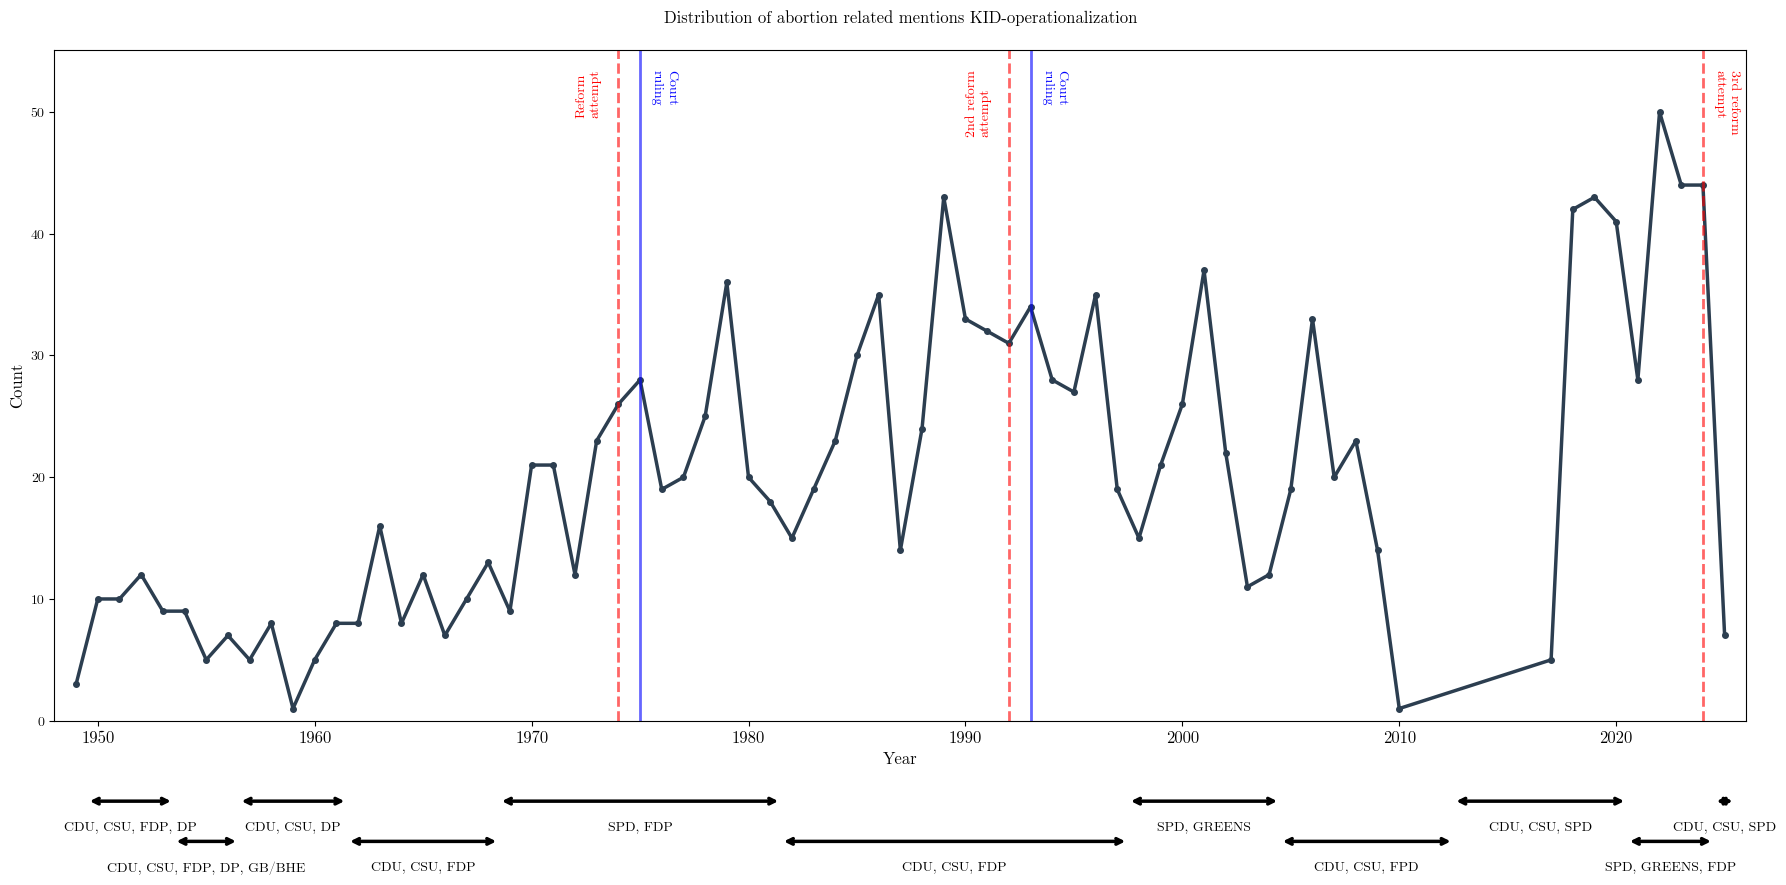

In [5]:
def Coal_histo(dataframe, coalitions):
    plt.figure(figsize=(18, 9))
    ax1 = plt.gca()
    
    # Count mentions per year and create line plot
    yearly_counts = dataframe['Year'].value_counts().sort_index()
    ax1.plot(yearly_counts.index, yearly_counts.values,
             linewidth=2.5, color='#2C3E50', marker='o', markersize=4)
    
    ax1.set_xlabel('Year', fontsize=12, weight='bold')
    ax1.set_xticklabels(ax1.get_xticks().astype(int), fontsize=12)
    ax1.set_ylabel('Count', fontsize=12, weight='bold')
    ax1.set_title(f'Distribution of abortion related mentions {dataframe.Name}',
                  fontsize=12, weight='bold', pad=20)
    
    # Y-axis limits after plotting
    y_min, y_max = ax1.get_ylim()
    ax1.set_ylim(0, y_max * 1.05)

    # ---- CREATE COALITION PERIODS ----
    coalition_periods = []
    current_coalition = None
    start_year = None
    
    for i, row in coalitions.iterrows():
        year = row.iloc[0]
        coalition = row.iloc[1]
        
        if coalition != current_coalition:
            if current_coalition is not None:
                coalition_periods.append((start_year, year - 1, current_coalition))
            current_coalition = coalition
            start_year = year
            
    if current_coalition is not None:
        coalition_periods.append((start_year, coalitions.iloc[-1, 0], current_coalition))

    # ---- DRAW COALITIONS OUTSIDE AXIS ----
    for i, (start, end, coalition) in enumerate(coalition_periods):

        # below the axis: -0.10 = 10% below
        base = -0.12
        level = i % 2
        y_offset = base - 0.06 * level  # stagger a little more

        # Arrow outside the axis canvas
        ax1.annotate(
            '',
            xy=(end + 0.5, y_offset), 
            xytext=(start - 0.5, y_offset),
            xycoords=('data', 'axes fraction'),
            arrowprops=dict(arrowstyle='<->', lw=2.5, color='black')
        )

        # Coalition label
        coalition_str = coalition.replace('[', '').replace(']', '').replace("'", "")

        ax1.text(
            (start + end) / 2,
            y_offset - 0.03,
            coalition_str,
            ha='center', va='top',
            fontsize=10, color='black',
            transform=ax1.get_xaxis_transform()
        )

    # ---- IMPORTANT EVENTS ----
    events = [
        (1974, 'Reform\nattempt', 'red', '--', -2, 90),
        (1975, 'Court\nruling', 'blue', '-', 0.5, -90),
        (1992, '2nd reform\nattempt', 'red', '--', -2, 90),
        (1993, 'Court\nruling', 'blue', '-', 0.5,-90),
        (2024, '3rd reform\nattempt', 'red', '--', .5, -90)
    ]
        
    for i in enumerate(events):
        year, label, color, style, distance, rotation = i[1]
        ax1.axvline(x=year, color=color, linestyle=style, lw=2, alpha=0.6)
        level = i[0] % 2
        
        
        ax1.text(
            year + distance,
            y_max * 1.02,
            label,
            ha='left', va='top',
            rotation=rotation,
            fontsize=10, color=color, weight='bold'    
        )
        
        
    ax1.set_xlim(dataframe['Year'].min() - 1, dataframe['Year'].max() + 1)
    
    plt.tight_layout()
    plt.savefig(f'./Outputs/{dataframe.Name}_Coalition_Histogram.png', dpi=300, bbox_inches='tight')
    plt.show()


Coal_histo(KID_results_df, coalitions)

In [6]:
# Add a plain integer year variable instead of individual dates to the individual sessions dataframe "LLM_A_corpus_df
def year_of_mention(df):
    Year = []

    for document in df['file_name']:
        file_path = f"../Speeches/IndividualSessions/{document.strip()}"
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                TextInhalt = file.read()
                TextClean = TextInhalt
                Year.append(dategetter(TextClean))
        except FileNotFoundError:
            Year.append(None)
    return Year

Year = year_of_mention(LLM_A_corpus_df)
LLM_A_corpus_df['Year'] = Year
LLM_A_corpus_df['Year'] = LLM_A_corpus_df['Year'].astype(str).str.extract(r'(\d{4})')

LLM_A_corpus_df.loc[LLM_A_corpus_df['Year'].isnull(), "Year"] = LLM_A_corpus_df["file_name"].str.extract(r'(\d{4})') # Fallback in case the year is not found in the text, extract it from the file_name

del Year

/tmp/ipykernel_33480/3061406980.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks().astype(int), fontsize=12)


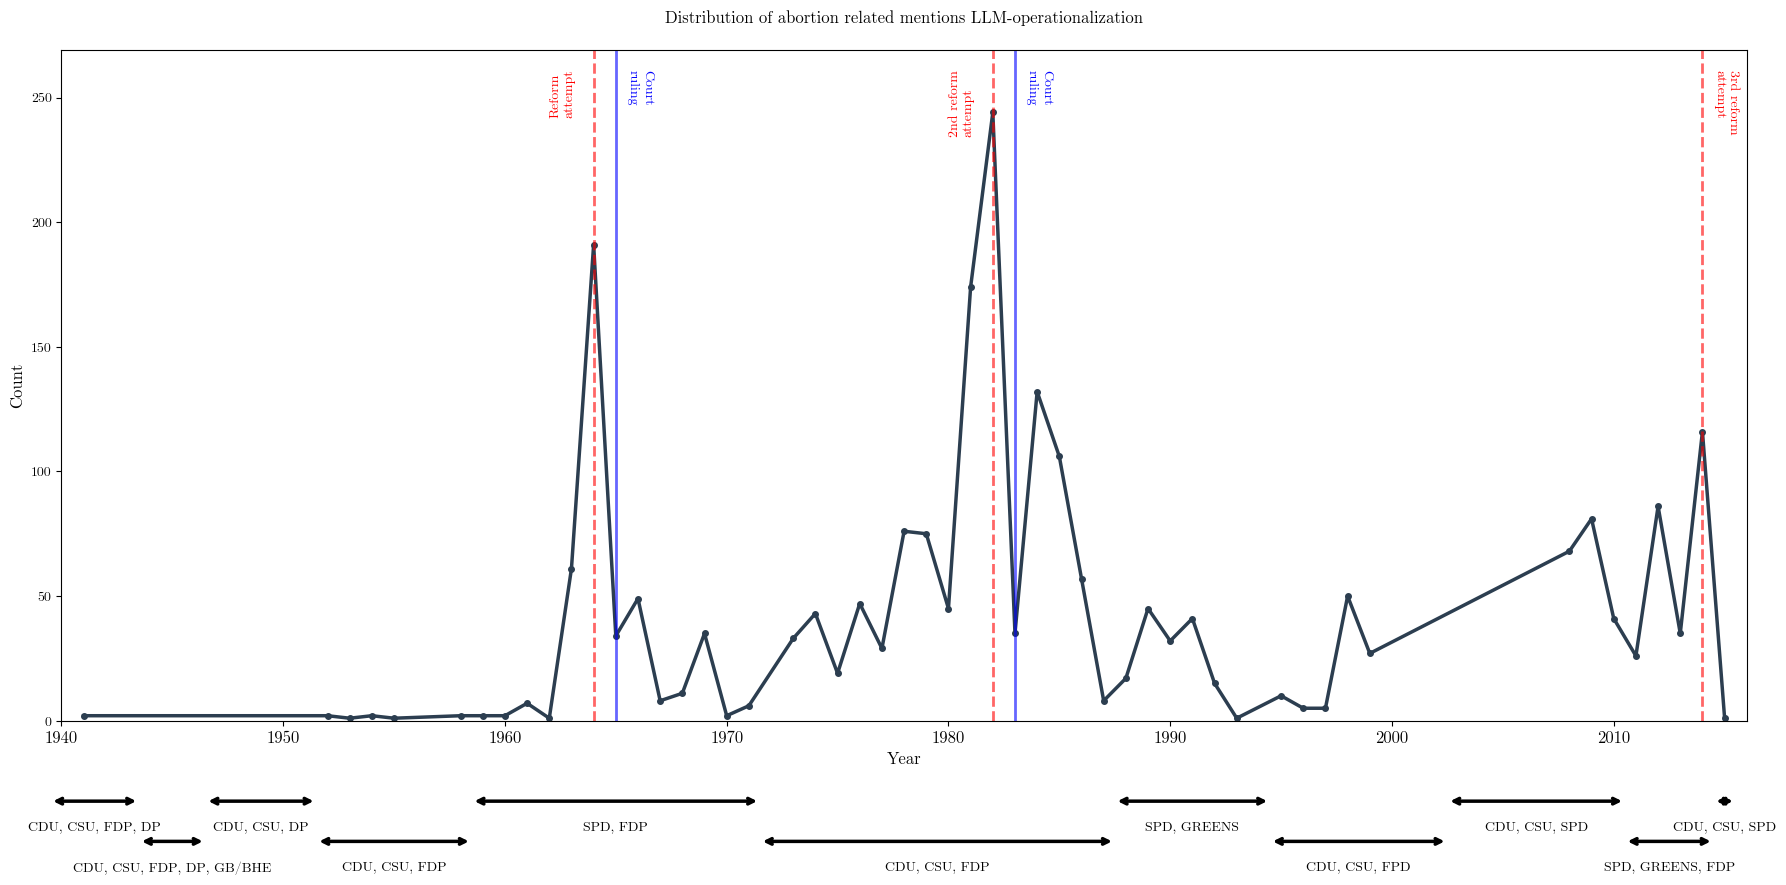

In [7]:
# Convert Year column to numeric for proper comparison
LLM_A_corpus_df['Year'] = pd.to_numeric(LLM_A_corpus_df['Year'], errors='coerce')
LLM_A_corpus_df = LLM_A_corpus_df.dropna(subset=['Year'])
LLM_A_corpus_df['Year'] = LLM_A_corpus_df['Year'].astype(int)
LLM_A_corpus_df.Name = "LLM-operationalization"

Coal_histo(LLM_A_corpus_df, coalitions)

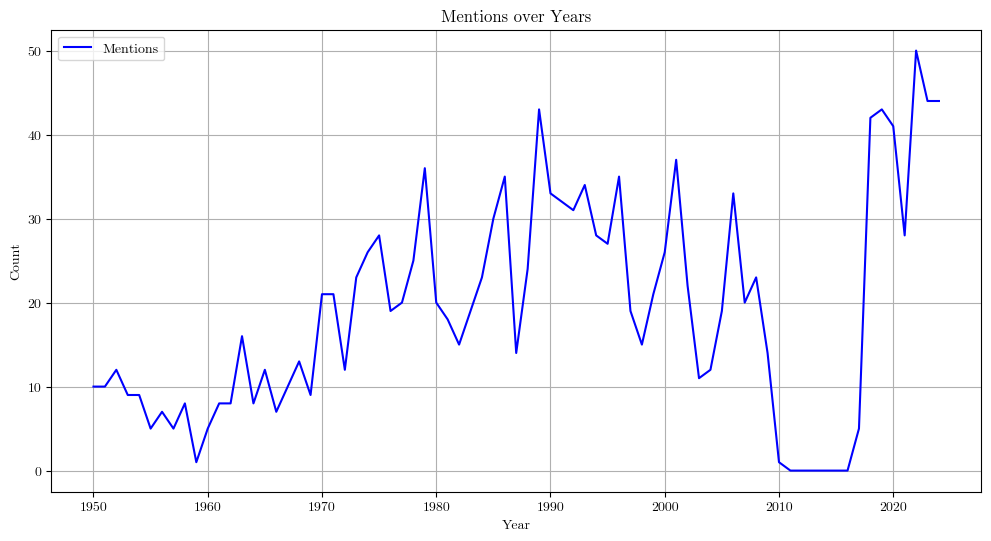

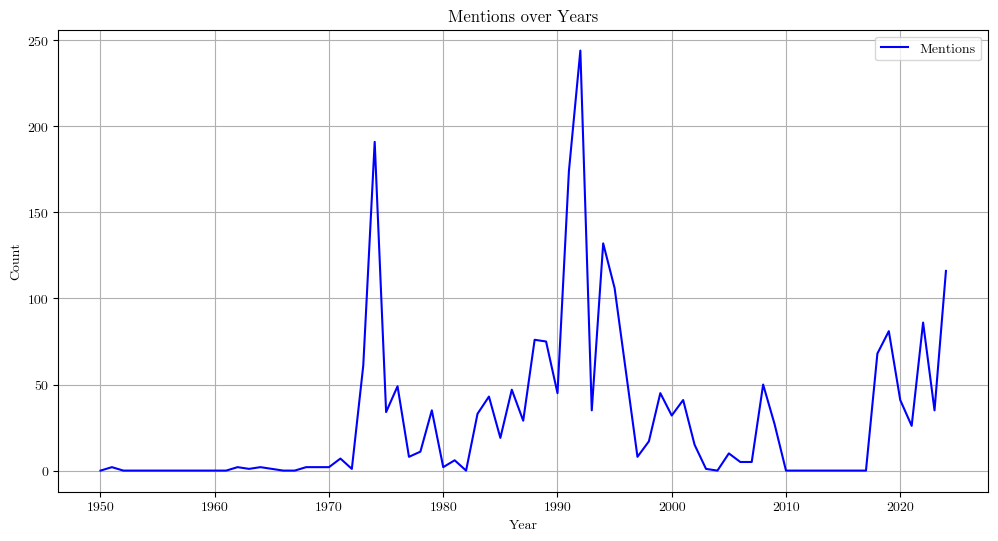

    Year  Mentions
0   1950        10
1   1951        10
2   1952        12
3   1953         9
4   1954         9
..   ...       ...
70  2020        41
71  2021        28
72  2022        50
73  2023        44
74  2024        44

[75 rows x 2 columns]
    Year  Mentions
0   1950         0
1   1951         2
2   1952         0
3   1953         0
4   1954         0
..   ...       ...
70  2020        41
71  2021        26
72  2022        86
73  2023        35
74  2024       116

[75 rows x 2 columns]


In [8]:
def ranging_mentions(dataframe, start_year=1950, end_year=2024):
    yearly_counts = pd.DataFrame(dataframe['Year'].value_counts().sort_index()).reset_index()
    yearly_counts.columns = ['Year', 'Mentions']
    yearly_counts['Year'] = pd.to_numeric(yearly_counts['Year'], errors='coerce')
    yearly_counts = yearly_counts.dropna(subset=['Year'])
    yearly_counts['Year'] = yearly_counts['Year'].astype(int)

    all_years_df = pd.DataFrame({'Year': range(1950, 2025)})
    all_years_df['Mentions'] = all_years_df['Year'].map(yearly_counts.set_index('Year')['Mentions']).fillna(0).astype(int)
    
    all_years_df['Year'] = all_years_df['Year'].astype(int)
    all_years_df['Mentions'] = all_years_df['Mentions'].astype(int)
    
    return all_years_df

def plot_mentions(dataframe, value_column='Year'):

    all_years_df = ranging_mentions(dataframe)
    plt.figure(figsize=(12, 6))
    plt.plot(all_years_df['Year'], all_years_df['Mentions'], label='Mentions', color='blue')

    plt.title('Mentions over Years')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.savefig('./Outputs/Mentions_over_Years.png', dpi=300)
    plt.show()

plot_mentions(KID_results_df)
plot_mentions(LLM_A_corpus_df)

print(ranging_mentions(KID_results_df))
print(ranging_mentions(LLM_A_corpus_df))

In [9]:
demographicsData = pd.read_csv("./CSV/Demographics.csv", header=0)
demographicsData['Births'] = demographicsData['Births'].str.replace(',', '.', regex=False).astype(float)
demographicsData['Deaths'] = demographicsData['Deaths'].str.replace(',', '.', regex=False).astype(float)

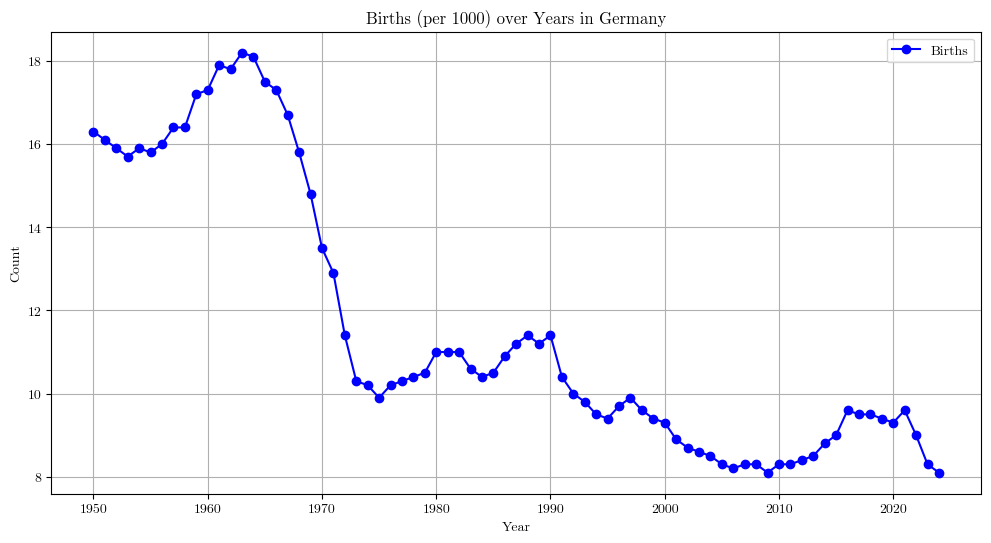

In [10]:
def plot_demograpficData(demographicsData):
    plt.figure(figsize=(12, 6))
    plt.plot(demographicsData['Year'], demographicsData['Births'], label='Births', color='blue', marker='o')
    
    plt.title('Births (per 1000) over Years in Germany')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.savefig('./Outputs/Demographic_Data.png', dpi=300)
    plt.show()
plot_demograpficData(demographicsData)

In [12]:
econData = pd.read_csv("./CSV/Macrodata_Piketty.csv", encoding='utf-8')
econData['LSI'] = econData['Labour share of income'].str.replace(',', '.', regex=False).astype(float)
econData['RoR'] = econData['Rate of return'].str.replace(',', '.', regex=False).astype(float)

econData.drop(columns=['Labour share of income', 'Rate of return'], inplace=True)

type(econData['Year'])
econData['Year'] = pd.to_numeric(econData['Year'], errors='coerce')
econData['Year'] = econData['Year'].astype('int')

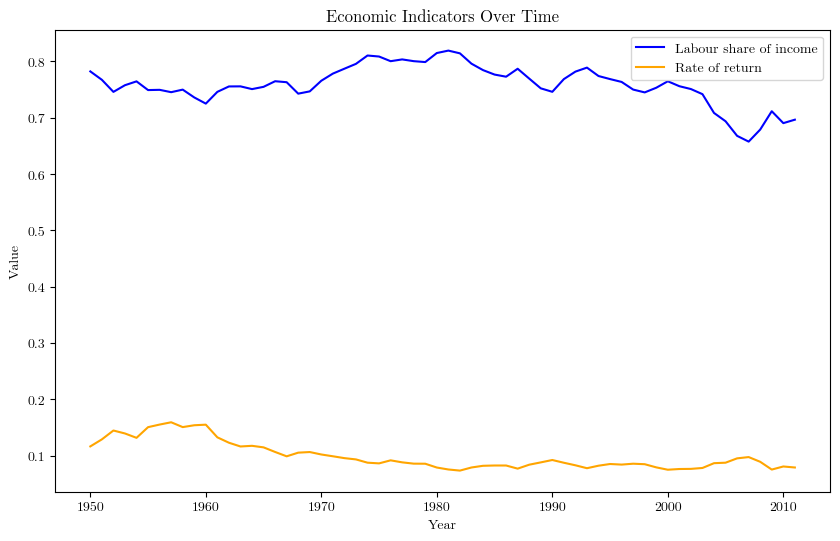

In [13]:
def plot_economic_indicators(econData):
    plt.figure(figsize=(10, 6))
    plt.plot(econData['Year'], econData['LSI'], label='Labour share of income', color='blue')
    plt.plot(econData['Year'], econData['RoR'], label='Rate of return', color='orange')
    plt.title('Economic Indicators Over Time')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend()
    plt.savefig('./Outputs/Economic_Indicators.png', dpi=300)
    plt.show()
plot_economic_indicators(econData)


In [14]:
econData = pd.merge(econData, demographicsData, on='Year', how='inner')

df_LLM_Op = ranging_mentions(LLM_A_corpus_df)
df_KID_Op = ranging_mentions(KID_results_df)


df_LLM_Op['Year'] = df_LLM_Op['Year'].astype(float)
econData['Year'] = econData['Year'].astype(float)

df_merged_KID = pd.merge(df_KID_Op, econData, on='Year', how='right')
df_merged_KID = pd.merge(df_merged_KID, coalitions, on='Year', how='left')
df_merged_KID['Mentions'] = df_merged_KID['Mentions'].fillna(0)

df_merged_LLM = pd.merge(df_LLM_Op, econData, on='Year', how='right')
df_merged_LLM = pd.merge(df_merged_LLM, coalitions, on='Year', how='left')
df_merged_LLM['Mentions'] = df_merged_LLM['Mentions'].replace(np.nan, 0)
year_cols = [col for col in df_merged_KID.columns if 'year' in col.lower() and col != 'Year']
if year_cols:
    df_merged_KID = df_merged_KID.drop(columns=year_cols)


def indexing_stuff(df):
    df_sorted = df.copy().sort_values(by='Year').reset_index(drop=True)
    
    df_sorted['YoY_LSI'] = df_sorted['LSI'].pct_change(periods=1) * 100
    df_sorted['YoY_RoR'] = df_sorted['RoR'].pct_change(periods=1) * 100
    df_sorted['YoY_Mentions'] = df_sorted['Mentions'].pct_change(periods=1) * 100
    
    
    df_sorted['YoY_Mentions'] = df_sorted['YoY_Mentions'].replace([np.nan, np.inf], 0)
    df_sorted = df_sorted.iloc[1:].reset_index(drop=True) #Dropping the first year to reduce bias
    
    return df_sorted

df_merged_KID_sorted = indexing_stuff(df_merged_KID)
df_merged_KID_sorted.Name = 'df_merged_KID_sorted'
df_merged_LLM_sorted = indexing_stuff(df_merged_LLM)
df_merged_LLM_sorted.Name = 'df_merged_LLM_sorted'

del df_merged_LLM, df_merged_KID, df_LLM_Op, df_KID_Op, demographicsData, econData

In [15]:
df_merged_LLM_sorted.Name = "LLM-annotated-dataframe"
df_merged_KID_sorted.Name = "KID-selected-dataframe"

/tmp/ipykernel_33480/4188171214.py:22: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax2.grid(False, alpha=0.3)


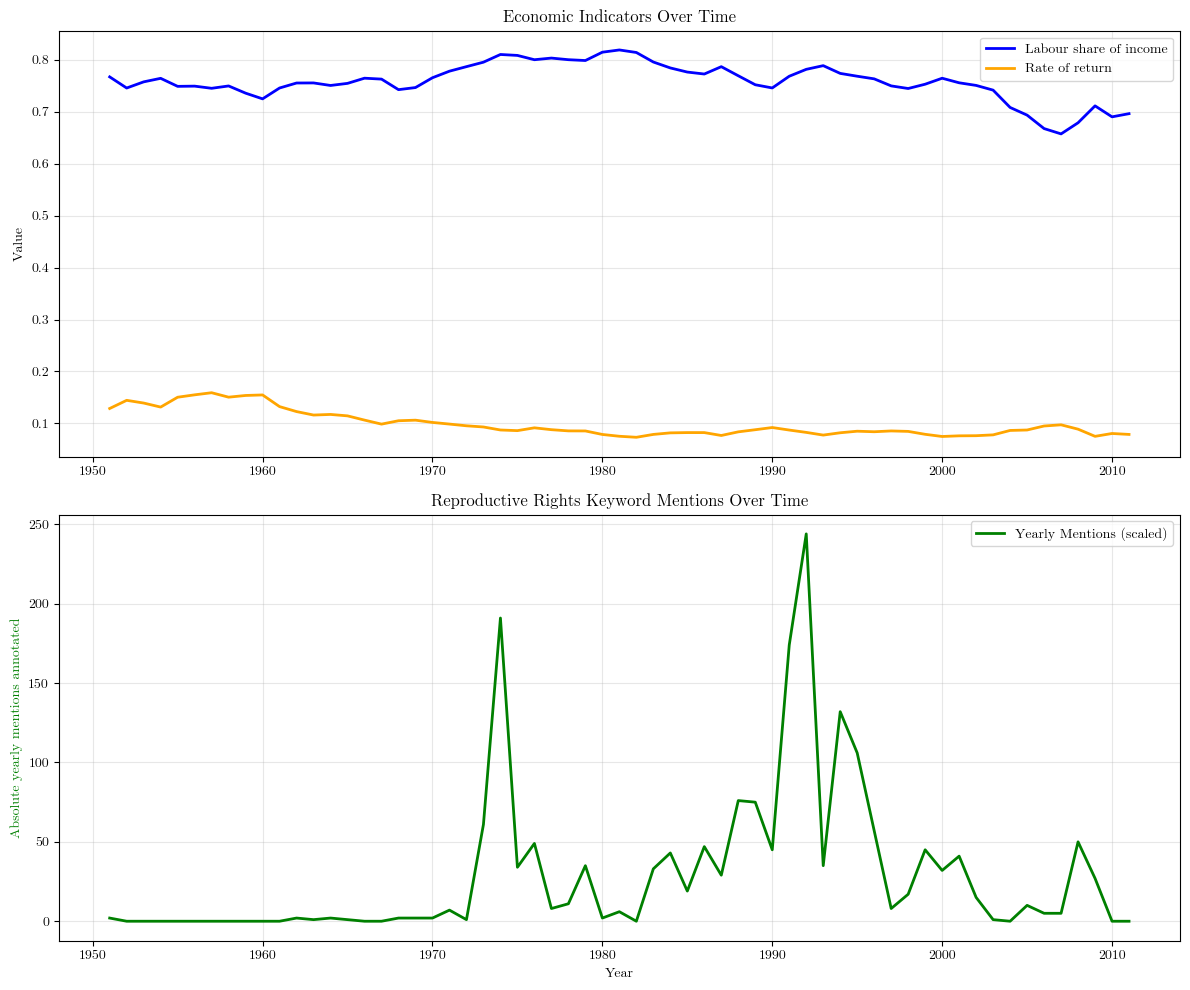

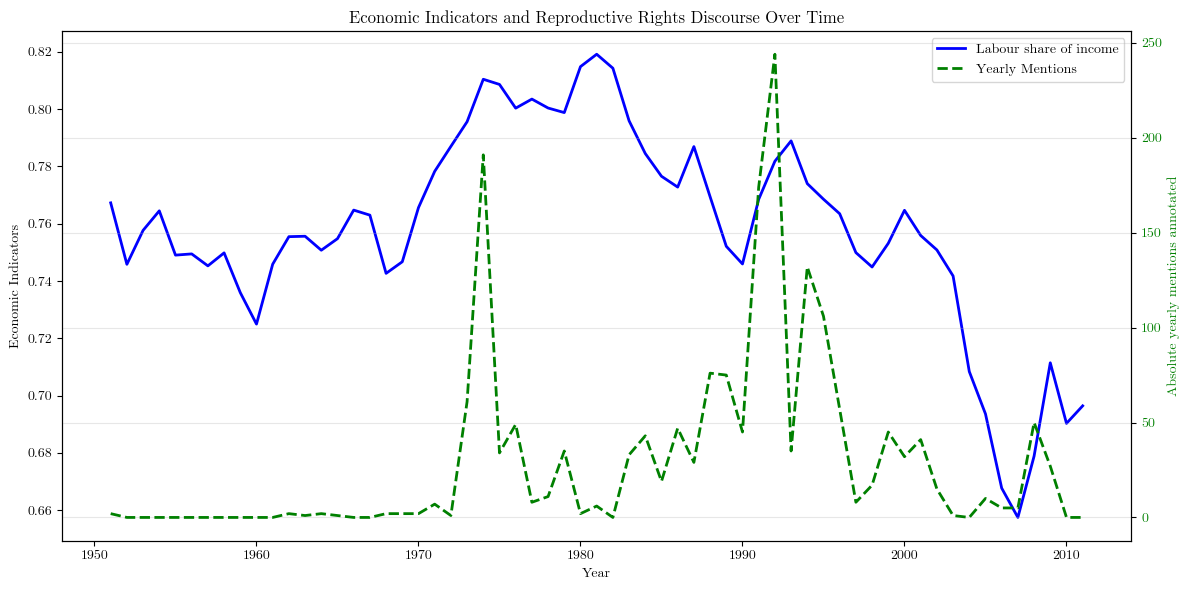

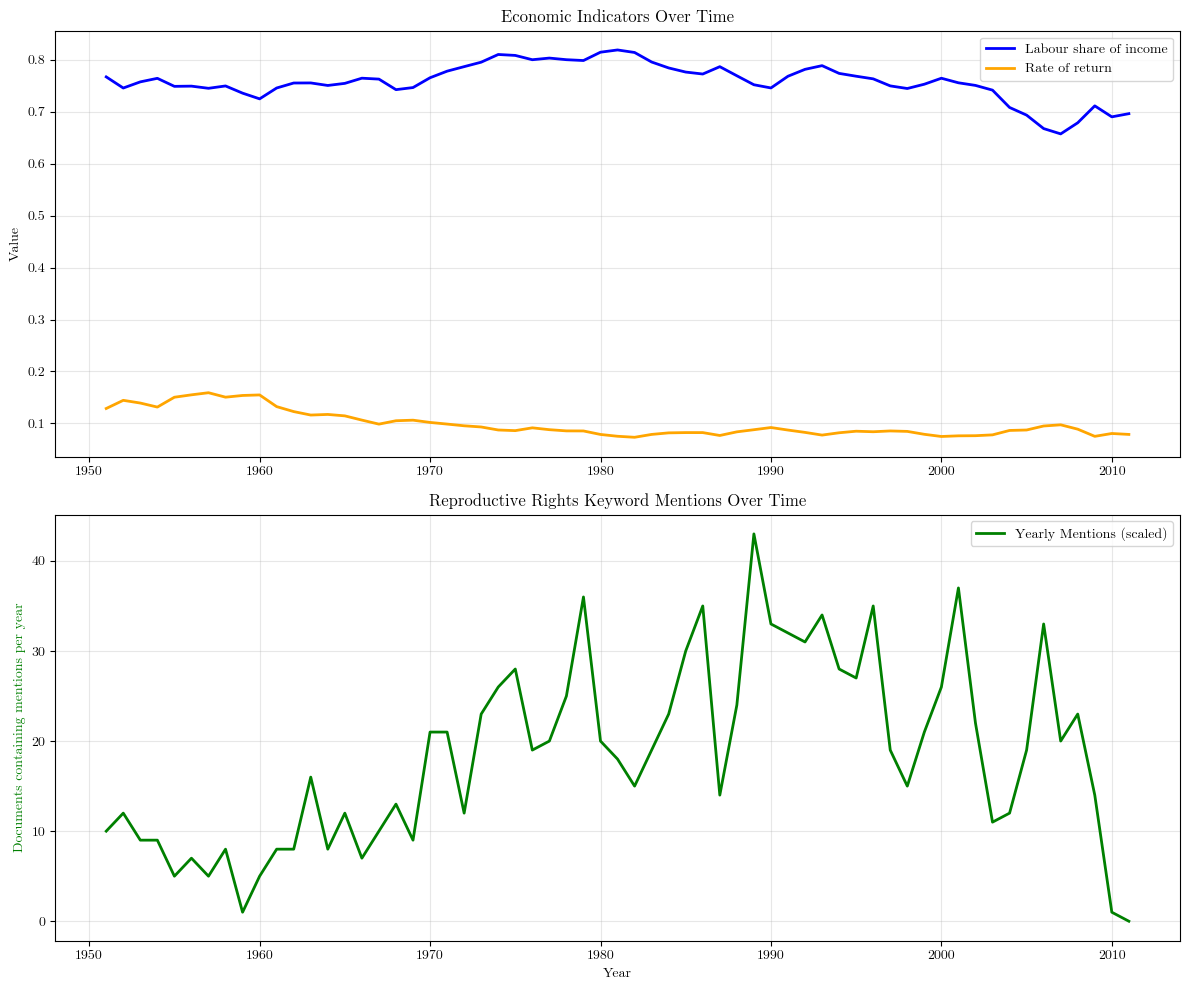

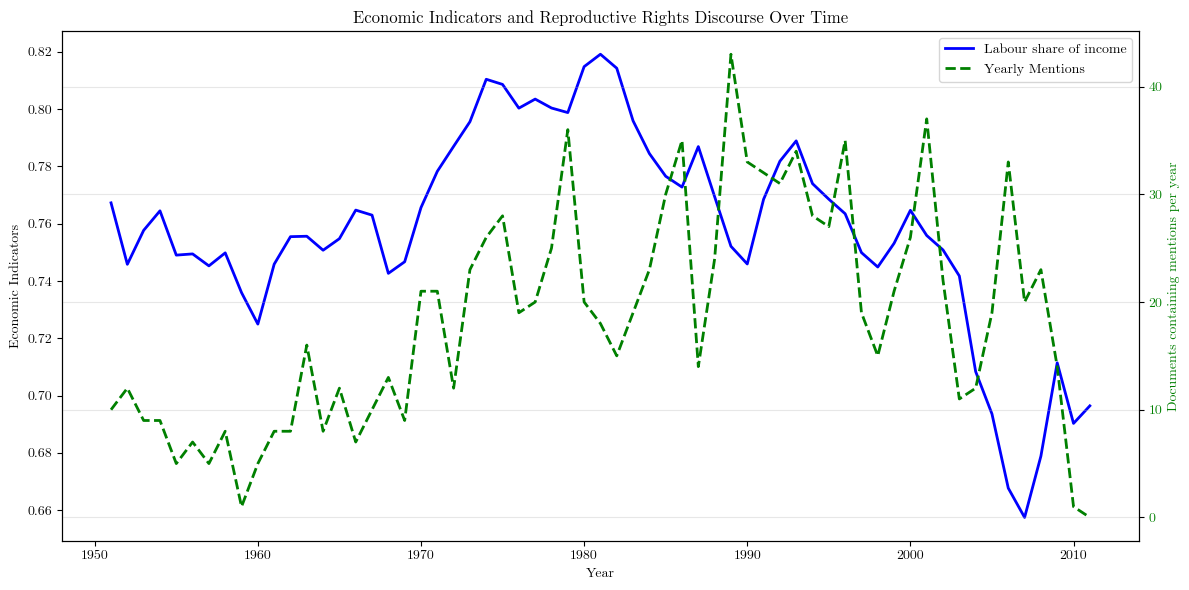

In [16]:
def plotting_stuff(dataframe):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

        ax1.plot(dataframe['Year'], dataframe['LSI'], 
                        label='Labour share of income', color='blue', linewidth=2)
        ax1.plot(dataframe['Year'], dataframe['RoR'], 
                        label='Rate of return', color='orange', linewidth=2)
        ax1.set_ylabel('Value')
        ax1.set_title('Economic Indicators Over Time')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2.plot(dataframe['Year'], dataframe['Mentions'], 
                        label='Yearly Mentions (scaled)', color='green', linewidth=2)
        ax2.set_xlabel('Year')
        if dataframe.Name == "LLM-annotated-dataframe":
                ax2.set_ylabel('Absolute yearly mentions annotated', color='green')
        elif dataframe.Name == "KID-selected-dataframe":
                ax2.set_ylabel('Documents containing mentions per year', color='green')
        ax2.set_title('Reproductive Rights Keyword Mentions Over Time')
        ax2.legend()
        ax2.grid(False, alpha=0.3)

        plt.tight_layout()
        plt.show()

        fig, ax1 = plt.subplots(figsize=(12, 6))


        ax1.plot(dataframe['Year'], dataframe['LSI'], 
                        label='Labour share of income', color='blue', linewidth=2)
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Economic Indicators', color='black')
        ax1.tick_params(axis='y', labelcolor='black')

        ax2 = ax1.twinx()
        ax2.plot(dataframe['Year'], dataframe['Mentions'], 
                        label='Yearly Mentions', color='green', linewidth=2, linestyle='--')
        
        if dataframe.Name == "LLM-annotated-dataframe":
                ax2.set_ylabel('Absolute yearly mentions annotated', color='green')
        elif dataframe.Name == "KID-selected-dataframe":
                ax2.set_ylabel('Documents containing mentions per year', color='green')
        
        ax2.tick_params(axis='y', labelcolor='green')

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

        plt.title('Economic Indicators and Reproductive Rights Discourse Over Time')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        filename = f'./Outputs/{getattr(dataframe, "name", "plot")}.png'
        plt.savefig(filename, dpi=300)
        plt.show()
        
plotting_stuff(df_merged_LLM_sorted)
plotting_stuff(df_merged_KID_sorted)

<Figure size 640x480 with 0 Axes>

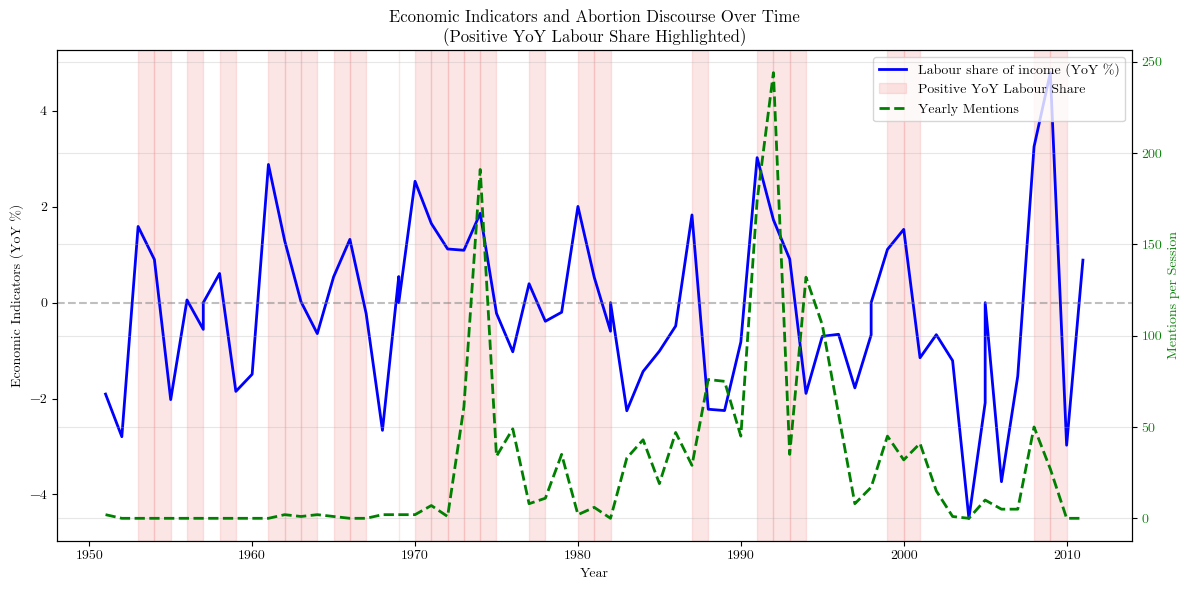

Years with positive YoY Labour share of income: [1953, 1954, 1956, 1958, 1961, 1962, 1963, 1965, 1966, 1969, 1970, 1971, 1972, 1973, 1974, 1977, 1980, 1981, 1987, 1991, 1992, 1993, 1999, 2000, 2008, 2009, 2011]


In [17]:
plt.tight_layout()
plt.show()
def plotting_more(df):
    
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot economic indicators on primary y-axis
    ax1.plot(df['Year'], df['YoY_LSI'], 
            label='Labour share of income (YoY %)', color='blue', linewidth=2)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Economic Indicators (YoY %)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Highlight positive YoY_Labour share periods
    positive_mask = df['YoY_LSI'] > 0
    for i, is_positive in enumerate(positive_mask):
        if is_positive and i < len(df) - 1:
            # Find consecutive positive periods
            year_start = df.iloc[i]['Year']
            year_end = df.iloc[i+1]['Year'] if i+1 < len(df) else year_start + 1
            ax1.axvspan(year_start, year_end, alpha=0.2, color='lightcoral', 
                    label='Positive YoY Labour Share' if i == positive_mask.idxmax() else "")

    # Add horizontal line at y=0 for reference
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    # Create secondary y-axis for mentions
    ax2 = ax1.twinx()
    ax2.plot(df['Year'], df['Mentions'], 
            label='Yearly Mentions', color='green', linewidth=2, linestyle='--')
    ax2.set_ylabel('Mentions per Session', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title('Economic Indicators and Abortion Discourse Over Time\n(Positive YoY Labour Share Highlighted)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
plotting_more(df_merged_LLM_sorted)

# Print the years with positive YoY Labour share
positive_years = df_merged_KID_sorted[df_merged_KID_sorted['YoY_LSI'] > 0]['Year'].tolist()
print(f"Years with positive YoY Labour share of income: {positive_years}")

In [18]:
df_merged_KID_sorted['Mentions_Lagged'] = df_merged_KID_sorted['Mentions'].shift(1)
df_merged_LLM_sorted['Mentions_Lagged'] = df_merged_LLM_sorted['Mentions'].shift(1)

df_merged_LLM_sorted.Name = 'df_merged_LLM_sorted'
df_merged_KID_sorted.Name = 'df_merged_KID_sorted'

In [19]:
from statsmodels.formula.api import ols
import stargazer
from stargazer.stargazer import Stargazer

def regressions(dataframe, name = 'df_merged_KID_sorted', dep = 'Mentions', ind = 'LSI', startyear=1950, endyear=2024):

    # Filter the dataframe for the specified years
    df_filtered = dataframe.loc[dataframe['Year'].between(startyear, endyear)]

    # Run OLS regressions
    result = ols(f'{dep} ~ {ind}', data=df_filtered).fit()

    
    beginningtex = """\\documentclass{report}
    \\usepackage{booktabs}
    \\begin{document}"""
    endtex = "\\end{document}"

    filename = f'regression_{startyear}-{endyear}_{name}_{ind}.tex'
    with open(filename, 'w') as f:
        f.write(beginningtex)
        f.write(result.summary().as_latex())
        f.write(endtex)
    return result

KID_result_1949_2025 = regressions(df_merged_KID_sorted, dep = "Mentions_Lagged", ind = "LSI")
KID_result_1949_1980 = regressions(df_merged_KID_sorted, dep = "Mentions_Lagged", ind = "LSI", startyear=1949, endyear=1980)
KID_result_1981_1990 = regressions(df_merged_KID_sorted, dep = "Mentions_Lagged", ind = "LSI", startyear=1981, endyear=1990)
KID_result_1991_2010 = regressions(df_merged_KID_sorted, dep = "Mentions_Lagged", ind = "LSI", startyear=1991, endyear=2010)

stargazer_tab = Stargazer([KID_result_1949_2025, KID_result_1949_1980, KID_result_1981_1990, KID_result_1991_2010])
stargazer_tab.title("OLS Regression Results KID-Operationalization")
stargazer_tab.custom_columns(["1949-2025", "1949-1980", "1981-1990", "1991-2010"], [1, 1, 1, 1])
print(stargazer_tab.render_latex())


\begin{table}[!htbp] \centering
  \caption{OLS Regression Results KID-Operationalization}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{4}{c}{\textit{Dependent variable: Mentions_Lagged}} \
\cr \cline{2-5}
\\[-1.8ex] & \multicolumn{1}{c}{1949-2025} & \multicolumn{1}{c}{1949-1980} & \multicolumn{1}{c}{1981-1990} & \multicolumn{1}{c}{1991-2010}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 Intercept & -31.261$^{}$ & -203.474$^{***}$ & 191.822$^{**}$ & -45.277$^{}$ \\
& (25.517) & (22.535) & (80.362) & (30.113) \\
 LSI & 65.437$^{*}$ & 282.642$^{***}$ & -214.797$^{*}$ & 94.233$^{**}$ \\
& (33.648) & (29.390) & (102.367) & (40.958) \\
\hline \\[-1.8ex]
 Observations & 65 & 31 & 11 & 22 \\
 $R^2$ & 0.057 & 0.761 & 0.329 & 0.209 \\
 Adjusted $R^2$ & 0.042 & 0.753 & 0.254 & 0.170 \\
 Residual Std. Error & 9.762 (df=63) & 4.103 (df=29) & 7.974 (df=9) & 7.370 (df=20) \\
 F Statistic & 3.782$^{*}$ (df=1; 63) & 92.485$^{***}$ (df=1; 29

In [ ]:
from scipy import stats

def pearsonsCorr(dataframe, start_year, end_year, ind = 'LSI'):
    dataframe = dataframe[(dataframe['Year'] >= start_year) & (dataframe['Year'] <= end_year)]
    res = stats.pearsonr(dataframe[ind], dataframe['Mentions'])
    print(f"Correlation coefficient: {res.statistic:.4f}")
    print(f"P-value: {res.pvalue:.6f}")
    print(f"Degrees of freedom: {len(dataframe) - 2}")
    return res

print("Pearson's correlation (LLM-A) for 1950 - 2025:\n")
pearsonsCorr(df_merged_LLM_sorted, 1950, 2025, ind= 'RoR')

print("\nPearson's correlation (LLM-A) for 1950 - 1980:\n")
pearsonsCorr(df_merged_LLM_sorted, 1949, 1980, ind= 'RoR')
print("\nPearson's correlation (LLM-A) for 1981 - 1990:\n")
pearsonsCorr(df_merged_LLM_sorted, 1981, 1990, ind= 'RoR')
print("\nPearson's correlation (LLM-A) for 1991 - 2010:\n")
pearsonsCorr(df_merged_LLM_sorted, 1991, 2010, ind= 'RoR')

print("\nPearson's correlation (KID) for 1949 - 2025:\n")
pearsonsCorr(df_merged_KID_sorted, 1949, 2025, ind= 'RoR')

print("\nPearson's correlation (KID) for 1949 - 1980:\n")
pearsonsCorr(df_merged_KID_sorted, 1949, 1980, ind= 'RoR')
print("\nPearson's correlation (KID) for 1981 - 1990:\n")
pearsonsCorr(df_merged_KID_sorted, 1981, 1990, ind= 'RoR')
print("\nPearson's correlation (KID) for 1991 - 2010:\n")
pearsonsCorr(df_merged_KID_sorted, 1991, 2010, ind= 'RoR')


Pearson's correlation (LLM-A)for 1950 - 2025:

Correlation coefficient: -0.3335
P-value: 0.006218
Degrees of freedom: 64

Pearson's correlation (LLM-A)for 1950 - 1980:

Correlation coefficient: -0.3930
P-value: 0.026056
Degrees of freedom: 30

Pearson's correlation (LLM-A)for 1981 - 1990:

Correlation coefficient: 0.7720
P-value: 0.005367
Degrees of freedom: 9

Pearson's correlation (LLM-A)for 1991 - 2010:

Correlation coefficient: -0.0366
P-value: 0.871651
Degrees of freedom: 20

Pearson's correlation (KID)for 1949 - 2025:

Correlation coefficient: -0.5890
P-value: 0.000000
Degrees of freedom: 64

Pearson's correlation (KID)for 1949 - 1980:

Correlation coefficient: -0.7910
P-value: 0.000000
Degrees of freedom: 30

Pearson's correlation (KID)for 1981 - 1990:

Correlation coefficient: 0.8392
P-value: 0.001239
Degrees of freedom: 9

Pearson's correlation (KID)for 1991 - 2010:

Correlation coefficient: 0.0358
P-value: 0.874407
Degrees of freedom: 20


PearsonRResult(statistic=np.float64(0.03577678164212744), pvalue=np.float64(0.874407367617173))

Correlation between LSI and Mentions: 0.2497


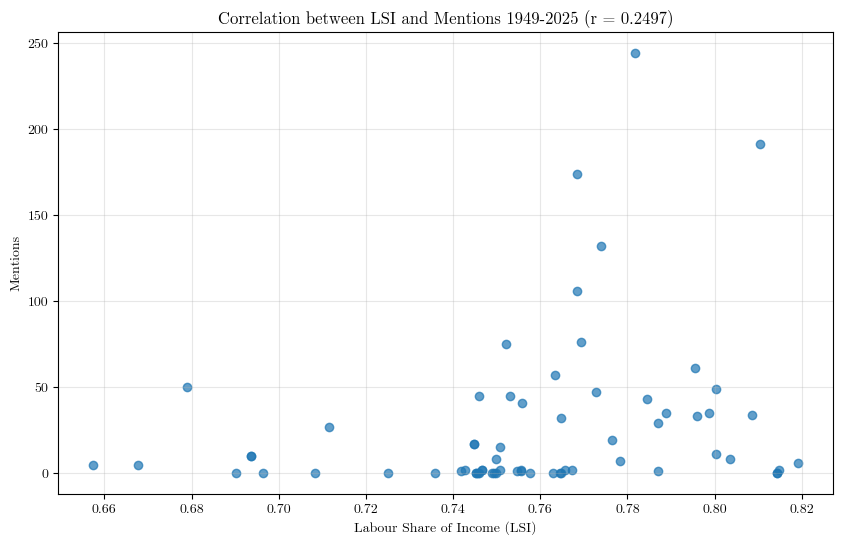

Correlation between LSI and Mentions: -0.8243


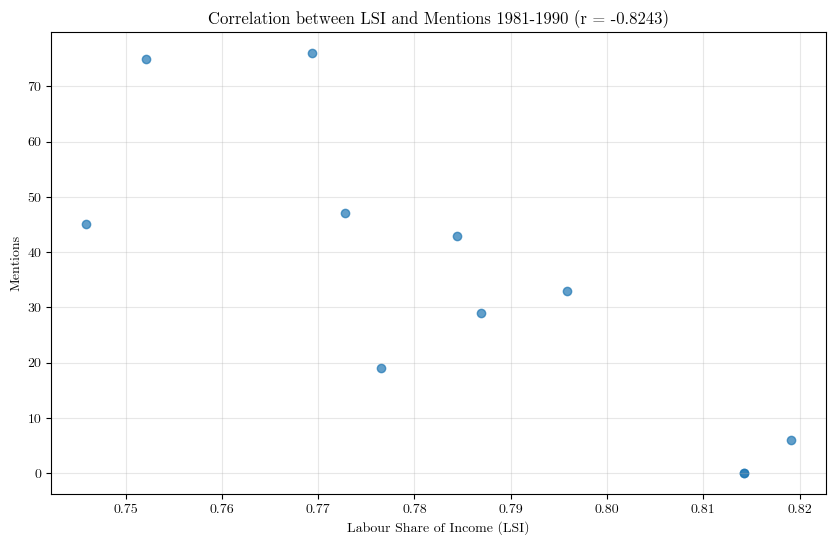

Correlation between LSI and Mentions: 0.5493


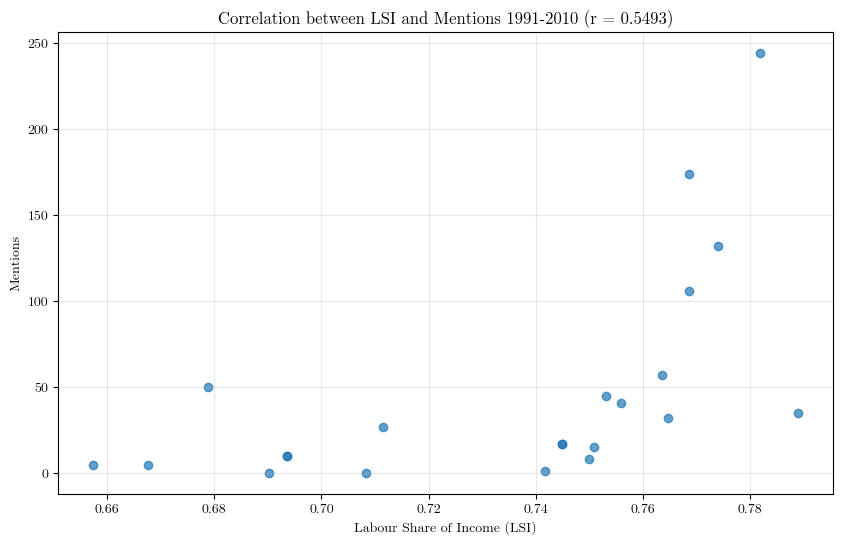

Correlation between LSI and Mentions: 0.2580


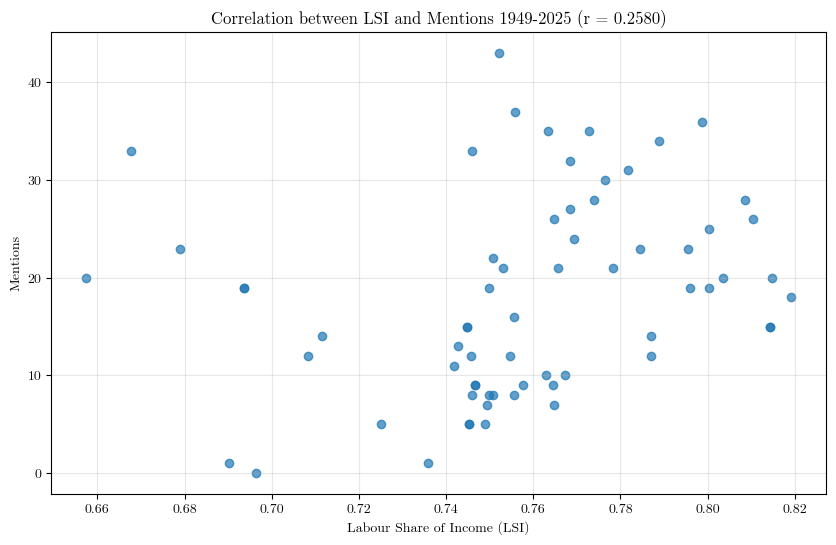

Correlation between LSI and Mentions: -0.8311


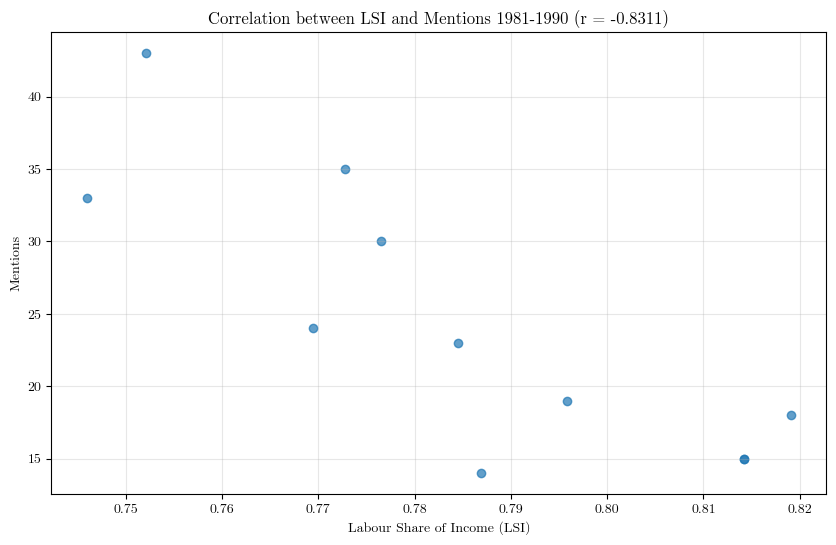

Correlation between LSI and Mentions: 0.4411


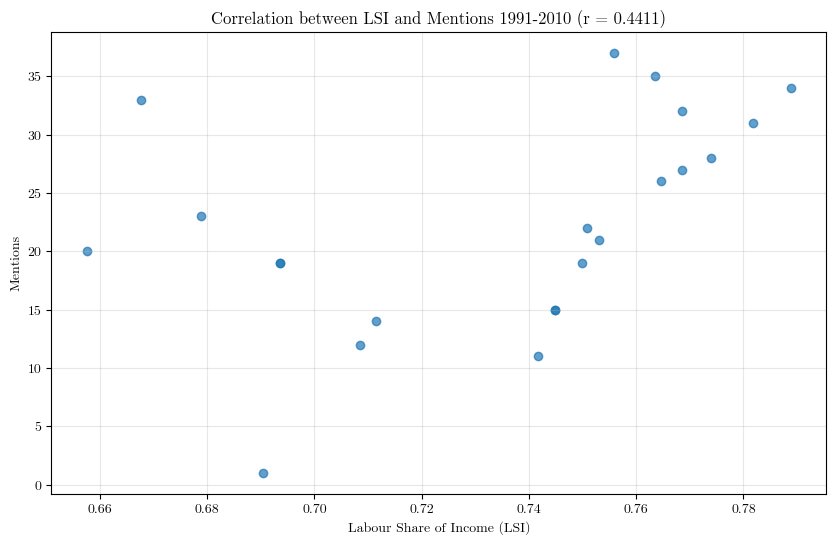

In [23]:

def correlate(dataframe, start_year, end_year):

    correlation = dataframe['LSI'].loc[dataframe['Year'].between(start_year, end_year)].corr(dataframe['Mentions'])
    print(f"Correlation between LSI and Mentions: {correlation:.4f}")
 

def plotCorrelation(dataframe, start_year, end_year):

    correlation = dataframe['LSI'].loc[dataframe['Year'].between(start_year, end_year)].corr(dataframe['Mentions'])
    print(f"Correlation between LSI and Mentions: {correlation:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(dataframe['LSI'].loc[dataframe['Year'].between(start_year, end_year)], dataframe['Mentions'].loc[dataframe['Year'].between(start_year, end_year)], alpha=0.7)
    plt.xlabel('Labour Share of Income (LSI)')
    plt.ylabel('Mentions')
    plt.title(f'Correlation between LSI and Mentions {start_year}-{end_year} (r = {correlation:.4f})')
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{dataframe.Name}_LSI_Mentions_Correlation_{start_year}_{end_year}.png', dpi=300)
    plt.show()
    
plotCorrelation(df_merged_LLM_sorted, 1949, 2025)
plotCorrelation(df_merged_LLM_sorted, 1981, 1990)
plotCorrelation(df_merged_LLM_sorted, 1991, 2010)

plotCorrelation(df_merged_KID_sorted, 1949, 2025)
plotCorrelation(df_merged_KID_sorted, 1981, 1990)
plotCorrelation(df_merged_KID_sorted, 1991, 2010)